## Problem Statement

The objective is to locate and recommend to the client which city and neighbourhood will be best choice to expand its daycare center franchise.

In [54]:

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
print('Folium installed')

#!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup
print('BeautifulSoup installed')

#!conda install -c anaconda lxml --yes
print('LXML parser installed')
import lxml.html
import lxml.html.soupparser
import requests
print('Libraries imported.')

Folium installed
BeautifulSoup installed
LXML parser installed
Libraries imported.


In [55]:
import pandas as pd
import numpy as np
#!conda install -c conda-forge geopy --yes 
import geopy.geocoders
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

geopy.geocoders.options.default_timeout = None

print('Geocoders installed')

Geocoders installed


In [6]:
#Using this function to create the coordinates for the neighborhoods dataframes

def getLocations(names, agent):
    #x=0
    location_list = []
    for name in names:
               
        geolocator_hood = Nominatim(user_agent=agent)
        location_hood = geolocator_hood.geocode(name)
        latitude_hood = location_hood.latitude
        longitude_hood = location_hood.longitude
       
        #x+=1
        # return only relevant information for each nearby venue
        location_list.append([(
            name, latitude_hood, longitude_hood)])
        #checking function operation and for any invalid locations
        
        #print('{}, {}, {}, {}.'.format(x, name, latitude_hood, longitude_hood))   
    
    neighbors = pd.DataFrame([item for location_list in location_list for item in location_list])
    neighbors.columns = ['Neighborhood', 
                         'Latitude', 
                         'Longitude']
 
       
    return(neighbors)
print('Function loaded...')

Function loaded...


## Build my dataframes

Let's first build our Census.gov dataframe to see which cities meet our criteria for a deeper dive.

In [11]:
API_key = 'xxxxxxxxxxxxxxxxx'
search_get = 'NAME,DP03_0015PE,DP03_0002E,DP02_0053PE,DP02_0015E'
year = '2017'
region_us = 'us:*'


#Definitions for the search_get: 
#Name = City or Borough
#DP03_0015PE = % Total - Under 6 years - Living with two parents - Both parents in labor force
#DP02_0015E = average family size
#DP03_0002E = labor force
#DP02_0053PE = percent of population enrolled in preschool/nursery school

census_api = 'https://api.census.gov/data/{}/acs/acs5/profile?get={}&for=place:*&key={}'.format(
    year,
    search_get,
    API_key
    )

census_national = 'https://api.census.gov/data/{}/acs/acs5/profile?get={}&for={}&key={}'.format(
    year,
    search_get,
    region_us,
    API_key
    )

#To look up variables:
#https://api.census.gov/data/2017/acs/acs5/profile/variables.html    

results = requests.get(census_api).json()

results_ntl = requests.get(census_national).json()

print(len(results))
results_ntl


29568


[['NAME', 'DP03_0015PE', 'DP03_0002E', 'DP02_0053PE', 'DP02_0015E', 'us'],
 ['United States', '65.2', '162184325', '6.0', '2.63', '1']]

In [13]:
census_city = pd.DataFrame(results, columns =['Region',
                                            '% of Two-parent Household in Labor Force',
                                            'Labor Force',
                                            '% pop. enrolled in preschool',
                                            'Average Family Size',
                                            'State',
                                            'FIPS'])

census_city = census_city.drop([0])

census_ntl = pd.DataFrame(results_ntl, columns =['Region',
                                            '% of Two-parent Household in Labor Force',
                                            'Labor Force',
                                            '% pop. enrolled in preschool',
                                            'Average Family Size',
                                            'FIPS'])

census_ntl = census_ntl.drop([0])
census_frames  = [census_city, census_ntl]

census_df = pd.concat(census_frames, sort=True, ignore_index=True)

#drop the extra columnms
census_df.drop(['State','FIPS'], axis=1, inplace=True)
census_df = census_df.drop([0])



#Cleaning up the city column
census_df['Region'] = census_df['Region'].str.split('city').str[0]

census_df = census_df.astype({"Labor Force": float})
census_df = census_df.astype({"% of Two-parent Household in Labor Force": float})

#Filter for the top20 largest cities in the dataset by total workforce
census_top = census_df.nlargest(25,'Labor Force')

#format the columns
census_top['Labor Force']=census_top['Labor Force'].div(1000).round(0)
census_top['% of Two-parent Household in Labor Force'] = census_top['% of Two-parent Household in Labor Force'].div(100).round(3)
census_top['% of Two-parent Household in Labor Force'] = census_top['% of Two-parent Household in Labor Force'].astype(float).map(lambda n: '{:.2%}'.format(n))
census_top['Labor Force']=census_top['Labor Force'].apply(lambda x: "{:,}".format(x))
#Rank the cities by % of Two-parent Household in Labor Force
census_top['Median Rank'] = census_top['% of Two-parent Household in Labor Force'].rank(ascending=0)
census_top.sort_values("Median Rank", inplace = True) 

#reorder the columns
census_top = census_top[['Median Rank','Region','% of Two-parent Household in Labor Force','Labor Force','% pop. enrolled in preschool','Average Family Size']]
census_top.style.set_table_styles([dict(selector="th",props=[('max-width', '50px')])])
census_top.set_index('Median Rank', inplace=True)
print("\n"'From the 2017 Census.gov dataset'"\n")

census_top.head(10)


From the 2017 Census.gov dataset



,Region,% of Two-parent Household in Labor Force,Labor Force,% pop. enrolled in preschool,Average Family Size
Median Rank,,,,,
1.0,Washington,74.50%,392.0,8.9,2.28
2.0,Boston,74.20%,394.0,4.0,2.36
3.0,Columbus,73.50%,475.0,5.3,2.40
4.0,San Francisco,71.30%,534.0,7.1,2.35
5.0,Philadelphia,70.30%,751.0,6.4,2.57
6.0,Charlotte,69.90%,466.0,7.0,2.57
7.0,Indianapolis,69.80%,445.0,6.1,2.51
8.0,Memphis,68.70%,322.0,5.8,2.55
9.5,Chicago,68.40%,"1,458.0",7.3,2.54


In [32]:

#Choosing the following cities to work with:
city_filter = [ 'Chicago ', 'Washington ', 'Boston ', 'United States']
census_filter = census_top[census_top.Region.isin(city_filter)]

census_filter.set_index('Region', inplace=True)

census_filter.rename(index={'Washington ':'Washington, DC','Boston ':'Boston','Chicago ':'Chicago','United States ':'United States'}, inplace=True)

#Format the headers
print("\n"'After inspecting the Census data, our client chose Washington, Boston, and Chicago for further review due to their high percentage of working parents and varied preschool enrollment.')
census_filter.style.set_table_styles([dict(selector="th",props=[('max-width', '125px')])])



After inspecting the Census data, our client chose Washington, Boston, and Chicago for further review due to their high percentage of working parents and varied preschool enrollment.


,% of Two-parent Household in Labor Force,Labor Force,% pop. enrolled in preschool,Average Family Size
Region,,,,
"Washington, DC",74.50%,392.0,8.9,2.28
Boston,74.20%,394.0,4.0,2.36
Chicago,68.40%,"1,458.0",7.3,2.54
United States,65.20%,"162,184.0",6.0,2.63


In [18]:
#Chicago neighborhood dataframe creation


chi_url = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').text
soup = BeautifulSoup(chi_url,'lxml')
#print(soup.prettify())

#Cleaning the dataframe

table = soup.find('table')
chi_df = pd.read_html(str(table))[0]

#Wikipedia included name without a location or bad data - let's remove them.
chi_df.set_index('Neighborhood', inplace=True)
# Delete these row indexes from dataFrame
neighborhood_filter = ['Sheffield Neighbors', 'Ashburn Estates', 'Belmont Heights', 'Cottage Grove Heights', 
                       'Fulton River District','Fifth City','Irving Woods','Central Station', 
                       'Jackson Park Highlands', 'Lakewood / Balmoral', 'Margate Park',
                      'Polish Downtown','Old Town Triangle', 'Old Town','Ranch Triangle','River North',
                      "River's Edge", "Saint Ben's",'Sheridan Station Corridor',"Talley's Corner",
                      'Wacławowo','West Chesterfield','Wrightwood Neighbors']
chi_df.drop(neighborhood_filter, inplace=True) 
#put the neighborhood index back into a column format
chi_df.reset_index(level=0, inplace=True)
chi_df.drop(['Community area'], axis=1, inplace=True)

#remove parenthesis from some values
chi_df['Neighborhood'] = chi_df['Neighborhood'].str.replace(r"\(.*\)","")

#chi_df.iloc[100:275]
chi_df.head(15)

,Neighborhood
0,Albany Park
1,Altgeld Gardens
2,Andersonville
3,Archer Heights
4,Armour Square
5,Ashburn
6,Auburn Gresham
7,Avalon Park
8,Avondale
9,Avondale Gardens


In [19]:
chi_names = []
for index, row in chi_df.iterrows():
     # access data using column names
    neighborhood_name = row['Neighborhood']
    address = neighborhood_name + ", Chicago"
    
    chi_names.append(address)

chi_locations = getLocations(names=chi_names, agent = 'city_explorer')
chi_locations.head()

,Neighborhood,Latitude,Longitude
0,"Albany Park, Chicago",41.971937,-87.716174
1,"Altgeld Gardens, Chicago",41.654864,-87.600446
2,"Andersonville, Chicago",41.977139,-87.669273
3,"Archer Heights, Chicago",41.811422,-87.726165
4,"Armour Square, Chicago",41.840033,-87.633107


In [20]:
#Clean up the neighborhood column and add a column to denote the metro area it belongs to:

chi_locations['Neighborhood'] = chi_locations['Neighborhood'].str.replace(", Chicago","")
chi_locations['Region'] = "Chicago"
#chi_locations.drop(['Metro Area'], axis=1, inplace=True)

chi_locations.head()

,Neighborhood,Latitude,Longitude,Region
0,Albany Park,41.971937,-87.716174,Chicago
1,Altgeld Gardens,41.654864,-87.600446,Chicago
2,Andersonville,41.977139,-87.669273,Chicago
3,Archer Heights,41.811422,-87.726165,Chicago
4,Armour Square,41.840033,-87.633107,Chicago


Loading the neighborhoods of DC into a dataframe

In [21]:
dc_url = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Washington,_D.C.').text
soup = BeautifulSoup(dc_url,'lxml')

dc_hoods = {}
for link in soup.find_all("a"):
    url = link.get("href", "")
    if "/wiki/" in url:
        dc_hoods[link.text.strip()] = url

#Build a pre-transposed dataframe, then remove incorrect values for Neighborhoods
dc_df_transposing = pd.DataFrame(dc_hoods, index = ['Wiki Link', 'District']) 
dc_df = dc_df_transposing.T
dc_df.index.name = 'Neighborhood'

# Delete these row indexes from dataFrame
dc_df = dc_df.drop(dc_df.index[0:6])
neighborhood_filter = [ 'Ward 2 Councilmember', 'Jack Evans','Howard University','Ward 3 Councilmember',
                       'Mary Cheh','Ward 4 Councilmember','Brandon Todd','Ward 5 Councilmember','Kenyan McDuffie',
                      'Ward 6 Councilmember','Charles Allen','Ward 7 Councilmember','Vince Gray',
                      'Ward 8 Councilmember','Trayon White','Sixteenth Street Heights','Mount Vernon Triangle',
                       'Sursum Corda','Southwest Federal Center','Colony Hill','Observatory Circle',
                      'Riggs Park','Barney Circle','East River Heights']
dc_df.drop(neighborhood_filter, inplace=True) 


dc_df.drop(['Wiki Link','District'], axis=1, inplace=True)
#put the neighborhood index back into a column format
dc_df.reset_index(level=0, inplace=True)
dc_df = dc_df.drop(dc_df.index[121:])
dc_df.head()

,Neighborhood
0,Adams Morgan
1,Columbia Heights
2,Kalorama
3,LeDroit Park
4,Mount Pleasant


In [22]:
dc_names = []
for index, row in dc_df.iterrows():
     # access data using column names
    neighborhood_name = row['Neighborhood']
    address = neighborhood_name + ", Washington DC"
    
    dc_names.append(address)

dc_locations = getLocations(names=dc_names, agent = 'city_explorer')
dc_locations.head()

,Neighborhood,Latitude,Longitude
0,"Adams Morgan, Washington DC",38.921500,-77.042199
1,"Columbia Heights, Washington DC",38.925672,-77.029429
2,"Kalorama, Washington DC",38.916778,-77.052477
3,"LeDroit Park, Washington DC",38.915907,-77.015721
4,"Mount Pleasant, Washington DC",38.930667,-77.040810


In [20]:
#clean up neighborhood column and add a column to denote the DC metro area it belongs to:

dc_locations['Neighborhood'] = dc_locations['Neighborhood'].str.replace(", Washington DC","")

dc_locations['Region'] = "Washington, DC"

dc_locations.head()

,Neighborhood,Latitude,Longitude,Region
0,Adams Morgan,38.921500,-77.042199,"Washington, DC"
1,Columbia Heights,38.925672,-77.029429,"Washington, DC"
2,Kalorama,38.916778,-77.052477,"Washington, DC"
3,LeDroit Park,38.915907,-77.015721,"Washington, DC"
4,Mount Pleasant,38.930667,-77.040810,"Washington, DC"


Building our dataframe for Boston neighborhoods

In [23]:
bos_url = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_Boston').text
soup = BeautifulSoup(bos_url,'lxml')

#print(soup.prettify())

In [24]:
bos_hoods = {}
for link in soup.find_all("a"):
    url = link.get("href", "")
    if "/wiki/" in url:
        bos_hoods[link.text.strip()] = url

#Build a pre-transposed dataframe, then remove incorrect values for Neighborhoods
bos_df_transposing = pd.DataFrame(bos_hoods, index = ['Wiki Link', 'District']) 
bos_df = bos_df_transposing.T
bos_df.index.name = 'Neighborhood'

neighborhood_filter = [ 'Leather District','Downtown']
bos_df.drop(neighborhood_filter, inplace=True) 

bos_df.rename(index = {"Fenway Kenmore": "Fenway"}, inplace = True) 


# Delete these row indexes from dataFrame
bos_df = bos_df.drop(bos_df.index[0:3])

bos_df = bos_df.drop(bos_df.index[21:])
bos_df['Region']='Boston'
bos_df.drop(['Wiki Link','District'], axis=1, inplace=True)

##put the neighborhood index back into a column format
bos_df.reset_index(level=0, inplace=True)
bos_df.head(25)

,Neighborhood,Region
0,Allston,Boston
1,Back Bay,Boston
2,Bay Village,Boston
3,Beacon Hill,Boston
4,Brighton,Boston
5,Charlestown,Boston
6,Chinatown,Boston
7,Dorchester,Boston
8,East Boston,Boston
9,Hyde Park,Boston


Retrieve our coordinates for the Boston neighborhoods

In [25]:
bos_names = []
for index, row in bos_df.iterrows():
     # access data using column names
    neighborhood_name = row['Neighborhood']
    address = neighborhood_name + ", Boston"
    
    bos_names.append(address)

bos_locations = getLocations(names=bos_names, agent = 'city_explorer')

In [26]:
bos_locations['Neighborhood'] = bos_locations['Neighborhood'].str.replace(", Boston","")
bos_locations['Region']='Boston'
bos_locations.head()

,Neighborhood,Latitude,Longitude,Region
0,Allston,42.355434,-71.132127,Boston
1,Back Bay,42.350707,-71.079730,Boston
2,Bay Village,42.350011,-71.066948,Boston
3,Beacon Hill,42.359820,-71.066162,Boston
4,Brighton,42.350097,-71.156442,Boston


In [33]:
 
census__filter = census_filter.drop('United States')

census_filter.reset_index(inplace=True)
census_filter.style.set_table_styles([dict(selector="th",props=[('max-width', '125px')])])


,Region,% of Two-parent Household in Labor Force,Labor Force,% pop. enrolled in preschool,Average Family Size
0,"Washington, DC",74.50%,392.0,8.9,2.28
1,Boston,74.20%,394.0,4.0,2.36
2,Chicago,68.40%,"1,458.0",7.3,2.54
3,United States,65.20%,"162,184.0",6.0,2.63


In [34]:

frames = [chi_locations, dc_locations, bos_locations]

#city_selections = pd.concat(frames, axis=1, join='inner')
city_selections = pd.concat(frames,  ignore_index=True)


city_df = pd.merge(city_selections, census_filter, sort=True, on='Region')
city_df.rename(columns={"Region": "Metro"}, inplace=True)
city_df.head()

#print(city_df.shape)

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Latitude,Longitude,Neighborhood,Metro,% of Two-parent Household in Labor Force,Labor Force,% pop. enrolled in preschool,Average Family Size
0,42.355434,-71.132127,Allston,Boston,74.20%,394.0,4.0,2.36
1,42.350707,-71.079730,Back Bay,Boston,74.20%,394.0,4.0,2.36
2,42.350011,-71.066948,Bay Village,Boston,74.20%,394.0,4.0,2.36
3,42.359820,-71.066162,Beacon Hill,Boston,74.20%,394.0,4.0,2.36
4,42.350097,-71.156442,Brighton,Boston,74.20%,394.0,4.0,2.36


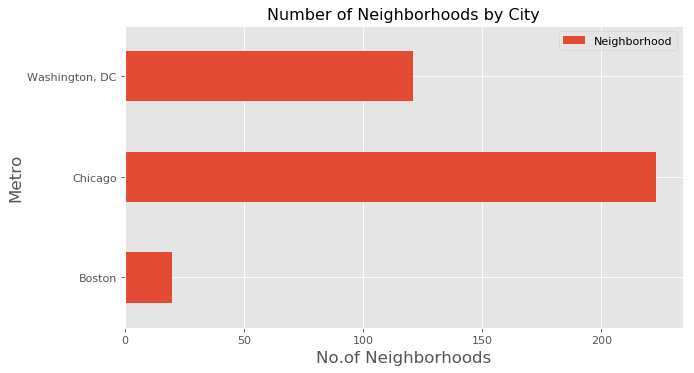

In [30]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighborhoods by City')
#On y-axis
plt.ylabel('Metro Area', fontsize = 15)
#On x-axis
plt.xlabel('No.of Neighborhoods', fontsize=15)
#giving a bar plot
city_df.groupby('Metro')['Neighborhood'].count().plot(kind='barh')
#legend
plt.legend()
plt.show()

Setting our the Foursquare API to pull in the daycare vendors

In [35]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxx' # your Foursquare ID
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxx' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PIOEJWDDQKDITPZIHTXAVLVGHTL5VGFTKBPLIZY5GCWWSSXL
CLIENT_SECRET:PG4RURUEQMV5XIE32HXNFPTZIFWEGEHVQZ01FOKF4NK00WZ5


In [36]:
def getNearbyVenues(names, latitudes, longitudes, metro_area, radius=500, search_query='child care'):
    
    venues_list=[]
    for name, lat, lng, metro in zip(names, latitudes, longitudes, metro_area):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            search_query)
        
            # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            pass
                           
        # return only relevant information for each nearby venue
       # print(name)
        venues_list.append([(
            name, 
            lat, 
            lng,
            metro,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Latitude', 'Longitude',
                             'Metro','Venue', 'Venue_Latitude', 'Venue_Longitude', 'Category']
    
    return(nearby_venues)

In [37]:
city_venues = getNearbyVenues(names=city_df['Neighborhood'],
                                   latitudes=city_df['Latitude'],
                                   longitudes=city_df['Longitude'],
                                   metro_area=city_df['Metro']
                                  )

print('There are {} uniques categories.'.format(len(city_venues['Category'].unique())))

There are 20 uniques categories.


In [38]:
city_venues[['Category']].head()

,Category
0,Hotel
1,Child Care Service
2,Daycare
3,School
4,Daycare


As we identified above, the Foursquare API delivered some questionable results from the Daycare search.  The following types of venues should only remain: 
Child Care Service, Daycare, Nursery School, and Preschool.  The Elementary School might have some early learning programs but most likely these venues 
are  geared for Kindergarten on up. 

In [39]:
#Venues needs to be filterd futher to identify childcare only facilities.
venues_filter = [ 'Child Care Service', 'Daycare', 'Nursery School', 'Preschool']
city_venues_filter = city_venues[city_venues.Category.isin(venues_filter)]

print('There are {} uniques categories.'.format(len(city_venues_filter['Category'].unique())))

There are 4 uniques categories.


Much better, we now have a better defined daycare dataframe to work from. 

In [40]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues_filter[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
city_onehot['Neighborhood'] = city_venues_filter['Neighborhood'] 
city_onehot['Metro'] = city_venues_filter['Metro'] 



# move neighborhood column to the first column
cols = list(city_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols.insert(0, cols.pop(cols.index('Metro')))


# use ix to reorder
city_onehot = city_onehot.loc[:, cols]

city_grouped = city_onehot.groupby('Neighborhood').mean().reset_index()


As expected, given it's fewer neighborhood count, Boston is dwarfed by Chicago and DC in daycare services.  However, 
 given a comparable labor force population and average family to DC, the lower facility count in Boston is more 
 conisistent with a lower preschool population indicating a less market saturation and greater opporutnity for growth.
'


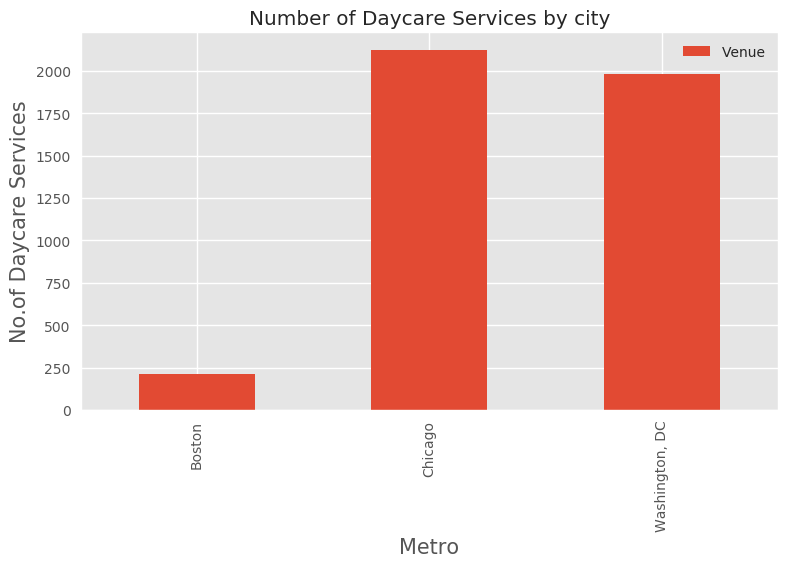

In [54]:
print("As expected, given it's fewer neighborhood count, Boston is dwarfed by Chicago and DC in daycare services."  
      "  However, \n given a comparable labor force population and average family to DC, the lower facility count in Boston is more" 
      " \n conisistent with a lower preschool population indicating a less market saturation and greater opporutnity for growth.\n'")

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Daycare Services by city')
#On x-axis
plt.xlabel('City', fontsize = 15)
#On y-axis
plt.ylabel('No.of Daycare Services', fontsize=15)
#giving a bar plot
city_venues_filter.groupby('Metro')['Venue'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


In [41]:
#Creating the Boston transformation for clustering

#Choosing the following cities to work with:
bos_filter = [ 'Boston']
boston_filter = city_venues_filter[city_venues_filter.Metro.isin(bos_filter)]

# one hot encoding
bos_onehot = pd.get_dummies(boston_filter[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bos_onehot['Neighborhood'] = boston_filter['Neighborhood'] 
bos_onehot['Metro'] = boston_filter['Metro'] 

# move neighborhood column to the first column
cols = list(bos_onehot)
# move the column to head of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('Neighborhood')))
cols.insert(0, cols.pop(cols.index('Metro')))

# use ix to reorder
bos_onehot = bos_onehot.loc[:, cols]

boston_grouped = bos_onehot.groupby('Neighborhood').mean().reset_index()

boston_grouped.head()

,Neighborhood,Child Care Service,Daycare,Nursery School,Preschool
0,Allston,0.333333,0.666667,0.000000,0.000000
1,Back Bay,0.153846,0.615385,0.076923,0.153846
2,Bay Village,0.000000,0.909091,0.000000,0.090909
3,Beacon Hill,0.000000,0.800000,0.000000,0.200000
4,Brighton,0.250000,0.750000,0.000000,0.000000


Let's use the Elbow method to find the best k value of centroids.

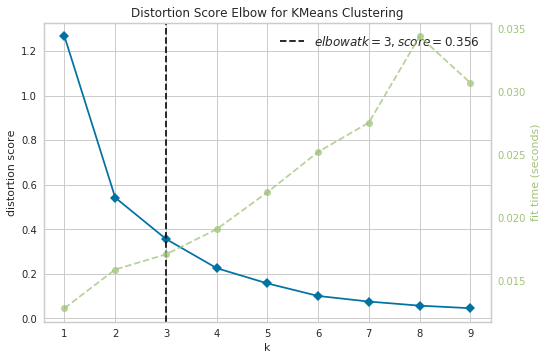

In [44]:
from sklearn.cluster import KMeans
#!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

X = boston_grouped.drop('Neighborhood', 1)

#instantiate the visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X)
visualizer.poof()

In [45]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#The Elbow method determined 2 clusters is most optimal
# set number of clusters
kclusters = 2

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0], dtype=int32)

What is the daycare facility makeup by neighborhood?

In [46]:
num_top_venues = 5

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
                venue  freq
0             Daycare  0.67
1  Child Care Service  0.33
2      Nursery School  0.00
3           Preschool  0.00


----Back Bay----
                venue  freq
0             Daycare  0.62
1  Child Care Service  0.15
2           Preschool  0.15
3      Nursery School  0.08


----Bay Village----
                venue  freq
0             Daycare  0.91
1           Preschool  0.09
2  Child Care Service  0.00
3      Nursery School  0.00


----Beacon Hill----
                venue  freq
0             Daycare   0.8
1           Preschool   0.2
2  Child Care Service   0.0
3      Nursery School   0.0


----Brighton----
                venue  freq
0             Daycare  0.75
1  Child Care Service  0.25
2      Nursery School  0.00
3           Preschool  0.00


----Charlestown----
                venue  freq
0             Daycare  0.62
1           Preschool  0.25
2      Nursery School  0.12
3  Child Care Service  0.00


----Chinatown----
                venu

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [48]:
import numpy as np
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Allston,Daycare,Child Care Service,Preschool,Nursery School
1,Back Bay,Daycare,Preschool,Child Care Service,Nursery School
2,Bay Village,Daycare,Preschool,Nursery School,Child Care Service
3,Beacon Hill,Daycare,Preschool,Nursery School,Child Care Service
4,Brighton,Daycare,Child Care Service,Preschool,Nursery School


In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

boston_merged = bos_locations

# merge boston_grouped with boston data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


#Clean up dataframe for NaN type errors.
boston_merged = boston_merged.dropna(how = 'any')
boston_merged.isna().sum()

boston_merged.head() 

,Neighborhood,Latitude,Longitude,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,Allston,42.355434,-71.132127,Boston,0,Daycare,Child Care Service,Preschool,Nursery School
1,Back Bay,42.350707,-71.079730,Boston,0,Daycare,Preschool,Child Care Service,Nursery School
2,Bay Village,42.350011,-71.066948,Boston,1,Daycare,Preschool,Nursery School,Child Care Service
3,Beacon Hill,42.359820,-71.066162,Boston,1,Daycare,Preschool,Nursery School,Child Care Service
4,Brighton,42.350097,-71.156442,Boston,0,Daycare,Child Care Service,Preschool,Nursery School


Mapping the neighborhoods by their cluster yeilds a clear view of daycare facility distribution and saturation around Boston.

In [52]:
# create map
map_clusters = folium.Map(location=[42.3602534, -71.0582912], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['Latitude'], boston_merged['Longitude'], boston_merged['Neighborhood'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)


***The preferred Boston neighborhoods for targeting franchise expansion are marked in red, given a market environment that reflects less saturation and competition for enrollment.***

In [53]:
       
boston_merged['Label']=boston_merged['Neighborhood']+', '+boston_merged['Region'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in boston_merged[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(map_clusters)         
map_clusters